<a href="https://colab.research.google.com/github/sumkh/ITI110_AgenticRAG/blob/main/LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AI Tutor Chatbot (Version 2.8)


### Setting Up - Install Requirements (Restart Session after installation)

In [1]:
%%capture
%pip install vllm huggingface_hub transformers langchain langchain_huggingface langgraph accelerate bitsandbytes langchain-core langchain-text-splitters langchain-community chromadb langchain-chroma langsmith docling langchain-docling sentence_transformers

In [2]:
%%capture
#%pip install -qU langchain-openai

### Load Packages

In [5]:
from google.colab import userdata
LANGSMITH_API_KEY=userdata.get("LANGSMITH_API_KEY")
HF_TOKEN = userdata.get("HF_TOKEN")

In [6]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Disable tokenizers parallelism, as it causes issues with multiprocessing
os.environ["LANGCHAIN_TRACING_V2"] = "true" # LangSmith for Observability
os.environ["LANGCHAIN_PROJECT"] = "AgenticRAG"
os.environ["LANGSMITH_API_KEY"] = LANGSMITH_API_KEY # Optional

from huggingface_hub import login
login(token=HF_TOKEN) # May be optional for getting model download from Huggingface

# Download required files from Github repo
!wget https://github.com/sumkh/NYP_Dataset/raw/refs/heads/main/Documents.zip
!unzip -o /content/Documents.zip


--2025-02-15 08:36:40--  https://github.com/sumkh/NYP_Dataset/raw/refs/heads/main/Documents.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sumkh/NYP_Dataset/refs/heads/main/Documents.zip [following]
--2025-02-15 08:36:40--  https://raw.githubusercontent.com/sumkh/NYP_Dataset/refs/heads/main/Documents.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18510909 (18M) [application/zip]
Saving to: ‘Documents.zip.1’

Documents.zip.1     100%[===================>]  17.65M  --.-KB/s    in 0.09s   

2025-02-15 08:36:40 (202 MB/s) - ‘Documents.zip.1’ saved [18510909/18510909]

Archive:  /content/Do

In [2]:
import os
import csv
import json
import hashlib
import uuid
import logging
from typing import List, Optional, Union, Literal, Dict
from dataclasses import dataclass, field

# LangChain & related imports
from langchain_core.tools import tool, StructuredTool
from pydantic import BaseModel, Field

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers import EnsembleRetriever, ContextualCompressionRetriever

# Extraction for Documents
from langchain_docling.loader import ExportType
from langchain_docling import DoclingLoader
from docling.chunking import HybridChunker

# Extraction for HTML
from langchain_community.document_loaders import WebBaseLoader
from urllib.parse import urlparse


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Configurations and Get the API key from the environment variable
EMBED_MODEL_ID = "sentence-transformers/all-MiniLM-L6-v2"

### Load Utils

In [7]:
# =============================================================================
#                         Document Extraction Functions
# =============================================================================

def extract_documents(doc_path: str) -> List[str]:
    """
    Recursively collects all file paths from folder 'doc_path'.
    Used by ExtractDocument.load_files() to find documents to parse.
    """
    extracted_docs = []

    for root, _, files in os.walk(doc_path):
        for file in files:
            file_path = os.path.join(root, file)
            extracted_docs.append(file_path)
    return extracted_docs


def _generate_uuid(page_content: str) -> str:
    """Generate a UUID for a chunk of text using MD5 hashing."""
    md5_hash = hashlib.md5(page_content.encode()).hexdigest()
    return str(uuid.UUID(md5_hash[0:32]))


def load_file(file_path: str) -> List[Document]:
    """
    Load a file from the given path and return a list of Document objects.
    """
    _documents = []

    # Load the file and extract the text chunks
    try:
        loader = DoclingLoader(
            file_path = file_path,
            export_type = ExportType.DOC_CHUNKS,
            chunker = HybridChunker(tokenizer=EMBED_MODEL_ID),
        )
        docs = loader.load()
        logger.info(f"Total parsed doc-chunks: {len(docs)} from Source: {file_path}")

        for d in docs:
            # Tag each document's chunk with the source file and a unique ID
            doc = Document(
                page_content=d.page_content,
                metadata={
                    "source": file_path,
                    "doc_id": _generate_uuid(d.page_content),
                    "source_type": "file",
                }
            )
            _documents.append(doc)
        logger.info(f"Total generated LangChain document chunks: {len(_documents)}\n.")

    except Exception as e:
        logger.error(f"Error loading file: {file_path}. Exception: {e}\n.")

    return _documents


# Define function to load documents from a folder
def load_files_from_folder(doc_path: str) -> List[Document]:
    """
    Load documents from the given folder path and return a list of Document objects.
    """
    _documents = []
    # Extract all files path from the given folder
    extracted_docs = extract_documents(doc_path)

    # Iterate through each document and extract the text chunks
    for file_path in extracted_docs:
        _documents.extend(load_file(file_path))

    return _documents

# =============================================================================
# Load structured data in csv file to LangChain Document format
def load_mcq_csvfiles(file_path: str) -> List[Document]:
    """
    Load structured data in mcq csv file from the given file path and return a list of Document object.
    Expected format: each row of csv is comma separated into "mcq_number", "mcq_type", "text_content"
    """
    _documents = []

    # iterate through each csv file and load each row into _dict_per_question format
    # Ensure we process only CSV files
    if not file_path.endswith(".csv"):
        return _documents  # Skip non-CSV files
    try:
        # Open and read the CSV file
        with open(file_path, mode='r', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            for row in reader:
                # Ensure required columns exist in the row
                if not all(k in row for k in ["mcq_number", "mcq_type", "text_content"]): # Ensure required columns exist and exclude header
                    logger.error(f"Skipping row due to missing fields: {row}")
                    continue
                # Tag each row of csv is comma separated into "mcq_number", "mcq_type", "text_content"
                doc = Document(
                    page_content = row["text_content"], # text_content segment is separated by "|"
                    metadata={
                        "source": f"{file_path}_{row['mcq_number']}",  # file_path + mcq_number
                        "doc_id": _generate_uuid(f"{file_path}_{row['mcq_number']}"),  # Unique ID
                        "source_type": row["mcq_type"],  # MCQ type
                    }
                )
                _documents.append(doc)
            logger.info(f"Successfully loaded {len(_documents)} LangChain document chunks from {file_path}.")

    except Exception as e:
        logger.error(f"Error loading file: {file_path}. Exception: {e}\n.")

    return _documents

# Define function to load documents from a folder for structured data in csv file
def load_files_from_folder_mcq(doc_path: str) -> List[Document]:
    """
    Load mcq csv file from the given folder path and return a list of Document objects.
    """
    _documents = []
    # Extract all files path from the given folder
    extracted_docs = [
        os.path.join(doc_path, file) for file in os.listdir(doc_path)
        if file.endswith(".csv")  # Process only CSV files
    ]

    # Iterate through each document and extract the text chunks
    for file_path in extracted_docs:
        _documents.extend(load_mcq_csvfiles(file_path))

    return _documents


# =============================================================================
#                         Website Extraction Functions
# =============================================================================
def _generate_uuid(page_content: str) -> str:
    """Generate a UUID for a chunk of text using MD5 hashing."""
    md5_hash = hashlib.md5(page_content.encode()).hexdigest()
    return str(uuid.UUID(md5_hash[0:32]))

def ensure_scheme(url):
    parsed_url = urlparse(url)
    if not parsed_url.scheme:
        return 'http://' + url  # Default to http, or use 'https://' if preferred
    return url

def extract_html(url: List[str]) -> List[Document]:
    if isinstance(url, str):
        url = [url]
    """
    Extracts text from the HTML content of web pages listed in 'web_path'.
    Returns a list of LangChain 'Document' objects.
    """
    # Ensure all URLs have a scheme
    web_paths = [ensure_scheme(u) for u in url]

    loader = WebBaseLoader(web_paths)
    loader.requests_per_second = 1
    docs = loader.load()

    # Iterate through each document, clean the content, removing excessive line return and store it in a LangChain Document
    _documents = []
    for doc in docs:
        # Clean the concent
        doc.page_content = doc.page_content.strip()
        doc.page_content = doc.page_content.replace("\n", " ")
        doc.page_content = doc.page_content.replace("\r", " ")
        doc.page_content = doc.page_content.replace("\t", " ")
        doc.page_content = doc.page_content.replace("  ", " ")
        doc.page_content = doc.page_content.replace("   ", " ")

        # Store it in a LangChain Document
        web_doc = Document(
            page_content=doc.page_content,
            metadata={
                "source": doc.metadata.get("source"),
                "doc_id": _generate_uuid(doc.page_content),
                "source_type": "web"
            }
        )
        _documents.append(web_doc)
    return _documents

# =============================================================================
#                         Vector Store Initialisation
# =============================================================================

embedding_model = HuggingFaceEmbeddings(model_name=EMBED_MODEL_ID)

# Initialise vector stores
general_vs = Chroma(
    collection_name="general_vstore",
    embedding_function=embedding_model,
    persist_directory="./general_db"
)

mcq_vs = Chroma(
    collection_name="mcq_vstore",
    embedding_function=embedding_model,
    persist_directory="./mcq_db"
)

in_memory_vs = Chroma(
    collection_name="in_memory_vstore",
    embedding_function=embedding_model
)

# Split the documents into smaller chunks for better embedding coverage
def split_text_into_chunks(docs: List[Document]) -> List[Document]:
    """
    Splits a list of Documents into smaller text chunks using
    RecursiveCharacterTextSplitter while preserving metadata.
    Returns a list of Document objects.
    """
    if not docs:
        return []
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000, # Split into chunks of 1000 characters
        chunk_overlap=200, # Overlap by 200 characters
        add_start_index=True
    )
    chunked_docs = splitter.split_documents(docs)
    return chunked_docs # List of Document objects


# =============================================================================
#                         Retrieval Tools
# =============================================================================

# Define a simple similarity search retrieval tool on msq_vs
class MCQRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    k: int = Field(2, title="Number of Results", description="The number of results to retrieve.")

def mcq_retriever(input: str, k: int = 2) -> List[str]:
    # Retrieve the top k most similar mcq question documents from the vector store
    docs_func = mcq_vs.as_retriever(
        search_type="similarity",
        search_kwargs={
        'k': k,
        'filter':{"source_type": "mcq_question"}
    },
    )
    docs_qns = docs_func.invoke(input, k=k)

    # Extract the document IDs from the retrieved documents
    doc_ids = [d.metadata.get("doc_id") for d in docs_qns if "doc_id" in d.metadata]

    # Retrieve full documents based on the doc_ids
    docs = mcq_vs.get(where = {'doc_id': {"$in":doc_ids}})

    qns_list = {}
    for i, d in enumerate(docs['metadatas']):
        qns_list[d['source'] + " " + d['source_type']] = docs['documents'][i]

    return qns_list

# Create a StructuredTool from the function
mcq_retriever_tool = StructuredTool.from_function(
    func = mcq_retriever,
    name = "MCQ Retrieval Tool",
    description = (
    """
    Use this tool to retrieve MCQ questions set when Human asks to generate a quiz related to a topic.
    DO NOT GIVE THE ANSWERS to Human before Human has answered all the questions.

    If Human give answers for questions you do not know, SAY you do not have the questions for the answer
    and ASK if the Human want you to generate a new quiz and then SAVE THE QUIZ with Summary Tool before ending the conversation.


    Input must be a JSON string with the schema:
        - input (str): The search topic to retrieve MCQ questions set related to the topic.
        - k (int): Number of question set to retrieve.
        Example usage: input='What is AI?', k=5

    Returns:
    - A dict of MCQ questions:
    Key: 'metadata of question' e.g. './Documents/mcq/mcq.csv_Qn31 mcq_question' with suffix ['question', 'answer', 'answer_reason', 'options', 'wrong_options_reason']
    Value: Text Content

    """
    ),
    args_schema = MCQRetrievalTool,
    response_format="content",
    return_direct = False, # Return the response as a list of strings
    verbose = False  # To log tool's progress
    )

# -----------------------------------------------------------------------------

# Retrieve more documents with higher diversity using MMR (Maximal Marginal Relevance) from the general vector store
# Useful if the dataset has many similar documents
class GenRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    k: int = Field(2, title="Number of Results", description="The number of results to retrieve.")

def gen_retriever(input: str, k: int = 2) -> List[str]:
    # Use retriever of vector store to retrieve documents
    docs_func = general_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )
    docs = docs_func.invoke(input, k=k)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
general_retriever_tool = StructuredTool.from_function(
    func = gen_retriever,
    name = "Assistant References Retrieval Tool",
    description = (
    """
    Use this tool to retrieve reference information from Assistant reference database for Human queries related to a topic or
    and when Human asked to generate guides to learn or study about a topic.

    Input must be a JSON string with the schema:
        - input (str): The user query.
        - k (int): Number of results to retrieve.
        Example usage: input='What is AI?', k=5
    Returns:
    - A list of retrieved document's content string.
    """
    ),
    args_schema = GenRetrievalTool,
    response_format="content",
    return_direct = False, # Return the content of the documents
    verbose = False  # To log tool's progress
    )

# -----------------------------------------------------------------------------

# Retrieve more documents with higher diversity using MMR (Maximal Marginal Relevance) from the in-memory vector store
# Query in-memory vector store only
class InMemoryRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    k: int = Field(2, title="Number of Results", description="The number of results to retrieve.")

def in_memory_retriever(input: str, k: int = 2) -> List[str]:
    # Use retriever of vector store to retrieve documents
    docs_func = in_memory_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )
    docs = docs_func.invoke(input, k=k)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
in_memory_retriever_tool = StructuredTool.from_function(
    func = in_memory_retriever,
    name = "In-Memory Retrieval Tool",
    description = (
    """
    Use this tool when Human ask Assistant to retrieve information from documents that Human has uploaded.

    Input must be a JSON string with the schema:
        - input (str): The user query.
        - k (int): Number of results to retrieve.
    """
    ),
    args_schema = InMemoryRetrievalTool,
    response_format="content",
    return_direct = False, # Whether to return the tool’s output directly
    verbose = False  # To log tool's progress
    )

# -----------------------------------------------------------------------------

# Web Extraction Tool
class WebExtractionRequest(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    url: str = Field(
        ...,
        title="url",
        description="urls to extract content from"
    )
    k: int = Field(5, title="Number of Results", description="The number of results to retrieve.")

# Extract content from a web URL, load into in_memory_vstore
def extract_web_path_tool(input: str, url: str, k: int = 5) -> List[str]:
    if isinstance(url, str):
        url = [url]
    """
    Extract content from the web URLs based on user's input.
    Args:
    - input: The input text to search for.
    - url: URLs to extract content from.
    - k: Number of results to retrieve.
    Returns:
     - A list of retrieved document's content string.
    """
    # Extract content from the web
    html_docs = extract_html(url)
    if not html_docs:
        return f"No content extracted from {url}."

    # Split the documents into smaller chunks for better embedding coverage
    chunked_texts = split_text_into_chunks(html_docs)
    in_memory_vs.add_documents(chunked_texts) # Add the chunked texts to the in-memory vector store

    # Extract content from the in-memory vector store
    # Use retriever of vector store to retrieve documents
    docs_func = in_memory_vs.as_retriever(
        search_type="mmr",
        search_kwargs={
        'k': k,
        'lambda_mult': 0.25,
        'filter':{"source": {"$in": url}}
    },
    )
    docs = docs_func.invoke(input, k=k)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
web_extraction_tool = StructuredTool.from_function(
    func = extract_web_path_tool,
    name = "Web Extraction Tool",
    description = (
        "Assistant should use this tool to extract content from web URLs based on user's input, "
        "Web extraction is initially load into database and then return k: Number of results to retrieve"
    ),
    args_schema = WebExtractionRequest,
    return_direct = False, # Whether to return the tool’s output directly
    verbose = False  # To log tool's progress
    )

# -----------------------------------------------------------------------------

# Ensemble Retrieval from General and In-Memory Vector Stores
class EnsembleRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    k: int = Field(5, title="Number of Results", description="The number of results to retrieve.")

def ensemble_retriever(input: str, k: int = 5) -> List[str]:
    # Use retriever of vector store to retrieve documents
    general_retrieval = general_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )
    in_memory_retrieval = in_memory_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )

    ensemble_retriever = EnsembleRetriever(
        retrievers=[general_retrieval, in_memory_retrieval],
        weights=[0.5, 0.5]
    )
    docs = ensemble_retriever.invoke(input)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
ensemble_retriever_tool = StructuredTool.from_function(
    func = ensemble_retriever,
    name = "Ensemble Retriever Tool",
    description = (
    """
    Use this tool to retrieve information from reference database and
    extraction of documents that Human has uploaded.

    Input must be a JSON string with the schema:
        - input (str): The user query.
        - k (int): Number of results to retrieve.
    """
    ),
    args_schema = EnsembleRetrievalTool,
    response_format="content",
    return_direct = False
    )


### Load Model Using Huggingface (Experimental)

In [ ]:
# https://huggingface.co/HuggingFaceTB/SmolLM2-1.7B-Instruct
from huggingface_hub import snapshot_download

local_path = "models/SmolLM2-Instruct"

snapshot_download(
    repo_id="HuggingFaceTB/SmolLM2-1.7B-Instruct",
    local_dir=local_path,
    revision="main",
    resume_download=True,
    cache_dir="./cache"
)
print("Model downloaded into "+ local_path)

In [6]:
# https://huggingface.co/docs/transformers/main_classes/pipelines
# Use a pipeline as a high-level helper
from transformers import pipeline
messages = [
    {"role": "user", "content": "Who are you?"},
]
pipe = pipeline("text-generation", model=local_path)
pipe(messages)

Device set to use cuda:0


[{'generated_text': [{'role': 'user', 'content': 'Who are you?'},
   {'role': 'assistant',
    'content': "I'm SmolLM, an AI model trained by Hugging Face. I'm here to assist"}]}]

In [7]:
print(pipe(messages)[0]['generated_text'][-1]['content'])

I'm SmolLM, an AI model trained by Hugging Face. I'm here to assist


In [19]:
from langchain_huggingface import HuggingFacePipeline, ChatHuggingFace
local_path = "models/SmolLM2-Instruct"

# https://python.langchain.com/docs/integrations/chat/huggingface/
llm = HuggingFacePipeline.from_model_id(
    #model_id=local_path,
    model_id="HuggingFaceTB/SmolLM2-1.7B-Instruct",
    task="text-generation",
    pipeline_kwargs=dict(
        max_new_tokens=8192,
        do_sample=False,
        repetition_penalty=1.03,
    ),
)

Device set to use cuda:0


In [14]:
from langchain_core.prompts import PromptTemplate

template = """Question: {question}

Answer: Let's think step by step."""
prompt = PromptTemplate.from_template(template)

chain = prompt | llm  # using llm directly from HuggingfacePipeline

question = "What is electroencephalography?"

print(chain.invoke({"question": question}))

Question: What is electroencephalography?

Answer: Let's think step by step. Electroencephalography (EEG) is a non-invasive neuroimaging technique used to measure the electrical activity of the brain. It is commonly used in clinical and research settings to diagnose and monitor neurological disorders, such as epilepsy, seizure disorders, and coma.


In [15]:
model = ChatHuggingFace(llm=llm, verbose=False)

messages = [
    {"role": "user", "content": "Who are you?"},
]

events = model.invoke(messages)
for event in events:
    print(event)

('content', "<|im_start|>system\nYou are a helpful AI assistant named SmolLM, trained by Hugging Face<|im_end|>\n<|im_start|>user\nWho are you?<|im_end|>\n<|im_start|>assistant\nI'm SmolLM, an AI model trained on the Hugging Face library. I'm here to assist you with your questions and provide information on various topics. I'm designed to be friendly, helpful, and easy to understand. Feel free to ask me anything you'd like to know!")
('additional_kwargs', {})
('response_metadata', {})
('type', 'ai')
('name', None)
('id', 'run-89bd3b9d-fb08-4f25-bf3a-14e65b6147d1-0')
('example', False)
('tool_calls', [])
('invalid_tool_calls', [])
('usage_metadata', None)


In [16]:
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate

template = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template("You are a helpful assistant."),
    HumanMessagePromptTemplate.from_template("{input}")
])

messages= template.format_messages(input="Who are you?")

events = model.invoke(messages)
for event in events:
    print(event)

('content', "<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nWho are you?<|im_end|>\n<|im_start|>assistant\nI'm an AI language model, developed to assist and answer questions to the best of my ability. I don't have personal experiences or opinions, but I can provide information on a wide range of topics. I'm here to help you with your queries, answer your questions, and provide information based on my training data.")
('additional_kwargs', {})
('response_metadata', {})
('type', 'ai')
('name', None)
('id', 'run-3a7d49ee-3ac1-4a18-b1b0-2414f7cd2933-0')
('example', False)
('tool_calls', [])
('invalid_tool_calls', [])
('usage_metadata', None)


In [ ]:
from langchain_core.prompts import PromptTemplate

template = """Question: {question}

Answer: Let's think step by step."""
prompt = PromptTemplate.from_template(template)

chain = prompt | llm

question = "What is electroencephalography?"

print(chain.invoke({"question": question}))

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Question: What is electroencephalography?

Answer: Let's think step by step. Electroencephalography (EEG) is a non-invasive neuroimaging technique used to measure the electrical activity of the brain. It is commonly used in clinical and research settings to diagnose and monitor neurological disorders, such as epilepsy, seizure disorders, and coma.


In [ ]:
for chunk in chain.stream(question):
    print(chunk, end="", flush=True)

 Electroencephalography (EEG) is a non-invasive neuroimaging technique used to measure the electrical activity of the brain. It is commonly used in clinical and research settings to diagnose and monitor neurological disorders, such as epilepsy, seizure disorders, and coma.

### Load Model and Serve Online (Experimental)

In [3]:
# Load and run the model:
!vllm serve "HuggingFaceTB/SmolLM2-1.7B-Instruct" --dtype=half

2025-02-13 17:35:29.364457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739468129.384918   48223 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739468129.391108   48223 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-13 17:35:29.418049: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO 02-13 17:35:32 __init__.py:190] Automatically detected platform cuda.
INFO 02-13 17:35:33 api_server.py:840] vLL

In [4]:
import torch
from langchain_openai import ChatOpenAI

inference_server_url = "http://localhost:8000/v1"

llm = ChatOpenAI(
    model="HuggingFaceTB/SmolLM2-1.7B-Instruct",
    openai_api_key="EMPTY", # max context window of 8192
    openai_api_base=inference_server_url,
    max_tokens=512,
    temperature=0.5
)


### Load Model Offline Locally

#### Define a Customised Wrapper from vLLM Wrapper

In [36]:
"""OpenAI chat wrapper."""

from __future__ import annotations

import base64
import json
import logging
import os
import sys
import warnings
from io import BytesIO
from math import ceil
from operator import itemgetter
from typing import (
    Any,
    AsyncIterator,
    Callable,
    Dict,
    Iterator,
    List,
    Literal,
    Mapping,
    Optional,
    Sequence,
    Tuple,
    Type,
    TypedDict,
    TypeVar,
    Union,
    cast,
)
from urllib.parse import urlparse

import openai
import tiktoken
from langchain_core._api.deprecation import deprecated
from langchain_core.callbacks import (
    AsyncCallbackManagerForLLMRun,
    CallbackManagerForLLMRun,
)
from langchain_core.language_models import LanguageModelInput
from langchain_core.language_models.chat_models import (
    BaseChatModel,
    LangSmithParams,
    agenerate_from_stream,
    generate_from_stream,
)
from langchain_core.messages import (
    AIMessage,
    AIMessageChunk,
    BaseMessage,
    BaseMessageChunk,
    ChatMessage,
    ChatMessageChunk,
    FunctionMessage,
    FunctionMessageChunk,
    HumanMessage,
    HumanMessageChunk,
    InvalidToolCall,
    SystemMessage,
    SystemMessageChunk,
    ToolCall,
    ToolMessage,
    ToolMessageChunk,
)
from langchain_core.messages.ai import (
    InputTokenDetails,
    OutputTokenDetails,
    UsageMetadata,
)
from langchain_core.messages.tool import tool_call_chunk
from langchain_core.output_parsers import JsonOutputParser, PydanticOutputParser
from langchain_core.output_parsers.openai_tools import (
    JsonOutputKeyToolsParser,
    PydanticToolsParser,
    make_invalid_tool_call,
    parse_tool_call,
)
from langchain_core.outputs import ChatGeneration, ChatGenerationChunk, ChatResult
from langchain_core.runnables import Runnable, RunnableMap, RunnablePassthrough, chain
from langchain_core.runnables.config import run_in_executor
from langchain_core.tools import BaseTool
from langchain_core.utils import get_pydantic_field_names
from langchain_core.utils.function_calling import (
    convert_to_openai_function,
    convert_to_openai_tool,
)
from langchain_core.utils.pydantic import (
    PydanticBaseModel,
    TypeBaseModel,
    is_basemodel_subclass,
)
from langchain_core.utils.utils import _build_model_kwargs, from_env, secret_from_env
from pydantic import BaseModel, ConfigDict, Field, SecretStr, model_validator
from pydantic.v1 import BaseModel as BaseModelV1
from typing_extensions import Self

logger = logging.getLogger(__name__)


def _convert_dict_to_message(_dict: Mapping[str, Any]) -> BaseMessage:
    """Convert a dictionary to a LangChain message.

    Args:
        _dict: The dictionary.

    Returns:
        The LangChain message.
    """
    role = _dict.get("role")
    name = _dict.get("name")
    id_ = _dict.get("id")
    if role == "user":
        return HumanMessage(content=_dict.get("content", ""), id=id_, name=name)
    elif role == "assistant":
        # Fix for azure
        # Also OpenAI returns None for tool invocations
        content = _dict.get("content", "") or ""
        additional_kwargs: Dict = {}
        if function_call := _dict.get("function_call"):
            additional_kwargs["function_call"] = dict(function_call)
        tool_calls = []
        invalid_tool_calls = []
        if raw_tool_calls := _dict.get("tool_calls"):
            additional_kwargs["tool_calls"] = raw_tool_calls
            for raw_tool_call in raw_tool_calls:
                try:
                    tool_calls.append(parse_tool_call(raw_tool_call, return_id=True))
                except Exception as e:
                    invalid_tool_calls.append(
                        make_invalid_tool_call(raw_tool_call, str(e))
                    )
        if audio := _dict.get("audio"):
            additional_kwargs["audio"] = audio
        return AIMessage(
            content=content,
            additional_kwargs=additional_kwargs,
            name=name,
            id=id_,
            tool_calls=tool_calls,
            invalid_tool_calls=invalid_tool_calls,
        )
    elif role in ("system", "developer"):
        if role == "developer":
            additional_kwargs = {"__openai_role__": role}
        else:
            additional_kwargs = {}
        return SystemMessage(
            content=_dict.get("content", ""),
            name=name,
            id=id_,
            additional_kwargs=additional_kwargs,
        )
    elif role == "function":
        return FunctionMessage(
            content=_dict.get("content", ""), name=cast(str, _dict.get("name")), id=id_
        )
    elif role == "tool":
        additional_kwargs = {}
        if "name" in _dict:
            additional_kwargs["name"] = _dict["name"]
        return ToolMessage(
            content=_dict.get("content", ""),
            tool_call_id=cast(str, _dict.get("tool_call_id")),
            additional_kwargs=additional_kwargs,
            name=name,
            id=id_,
        )
    else:
        return ChatMessage(content=_dict.get("content", ""), role=role, id=id_)  # type: ignore[arg-type]


def _format_message_content(content: Any) -> Any:
    """Format message content."""
    if content and isinstance(content, list):
        # Remove unexpected block types
        formatted_content = []
        for block in content:
            if (
                isinstance(block, dict)
                and "type" in block
                and block["type"] == "tool_use"
            ):
                continue
            else:
                formatted_content.append(block)
    else:
        formatted_content = content

    return formatted_content


def _convert_message_to_dict(message: BaseMessage) -> dict:
    """Convert a LangChain message to a dictionary.

    Args:
        message: The LangChain message.

    Returns:
        The dictionary.
    """
    message_dict: Dict[str, Any] = {"content": _format_message_content(message.content)}
    if (name := message.name or message.additional_kwargs.get("name")) is not None:
        message_dict["name"] = name

    # populate role and additional message data
    if isinstance(message, ChatMessage):
        message_dict["role"] = message.role
    elif isinstance(message, HumanMessage):
        message_dict["role"] = "user"
    elif isinstance(message, AIMessage):
        # Fix for azure
        content = message.content or ""
        message_dict["role"] = "assistant"
        if "function_call" in message.additional_kwargs:
            message_dict["function_call"] = message.additional_kwargs["function_call"]
        if message.tool_calls or message.invalid_tool_calls:
            message_dict["tool_calls"] = [
                _lc_tool_call_to_openai_tool_call(tc) for tc in message.tool_calls
            ] + [
                _lc_invalid_tool_call_to_openai_tool_call(tc)
                for tc in message.invalid_tool_calls
            ]
        elif "tool_calls" in message.additional_kwargs:
            message_dict["tool_calls"] = message.additional_kwargs["tool_calls"]
            tool_call_supported_props = {"id", "type", "function"}
            message_dict["tool_calls"] = [
                {k: v for k, v in tool_call.items() if k in tool_call_supported_props}
                for tool_call in message_dict["tool_calls"]
            ]
        else:
            pass
        # If tool calls present, content null value should be None not empty string.
        if "function_call" in message_dict or "tool_calls" in message_dict:
            message_dict["content"] = message_dict["content"] or None

        if "audio" in message.additional_kwargs:
            raw_audio = message.additional_kwargs["audio"]
            audio = (
                {"id": message.additional_kwargs["audio"]["id"]}
                if "id" in raw_audio
                else raw_audio
            )
            message_dict["audio"] = audio
    elif isinstance(message, SystemMessage):
        message_dict["role"] = message.additional_kwargs.get(
            "__openai_role__", "system"
        )
    elif isinstance(message, FunctionMessage):
        message_dict["role"] = "function"
    elif isinstance(message, ToolMessage):
        message_dict["role"] = "tool"
        message_dict["tool_call_id"] = message.tool_call_id
        supported_props = {"content", "role", "tool_call_id"}
        message_dict = {k: v for k, v in message_dict.items() if k in supported_props}
    else:
        raise TypeError(f"Got unknown type {message}")
    return message_dict


def _convert_delta_to_message_chunk(
    _dict: Mapping[str, Any], default_class: Type[BaseMessageChunk]
) -> BaseMessageChunk:
    id_ = _dict.get("id")
    role = cast(str, _dict.get("role"))
    content = cast(str, _dict.get("content") or "")
    additional_kwargs: Dict = {}
    if _dict.get("function_call"):
        function_call = dict(_dict["function_call"])
        if "name" in function_call and function_call["name"] is None:
            function_call["name"] = ""
        additional_kwargs["function_call"] = function_call
    tool_call_chunks = []
    if raw_tool_calls := _dict.get("tool_calls"):
        additional_kwargs["tool_calls"] = raw_tool_calls
        try:
            tool_call_chunks = [
                tool_call_chunk(
                    name=rtc["function"].get("name"),
                    args=rtc["function"].get("arguments"),
                    id=rtc.get("id"),
                    index=rtc["index"],
                )
                for rtc in raw_tool_calls
            ]
        except KeyError:
            pass

    if role == "user" or default_class == HumanMessageChunk:
        return HumanMessageChunk(content=content, id=id_)
    elif role == "assistant" or default_class == AIMessageChunk:
        return AIMessageChunk(
            content=content,
            additional_kwargs=additional_kwargs,
            id=id_,
            tool_call_chunks=tool_call_chunks,
        )
    elif role in ("system", "developer") or default_class == SystemMessageChunk:
        if role == "developer":
            additional_kwargs = {"__openai_role__": "developer"}
        else:
            additional_kwargs = {}
        return SystemMessageChunk(
            content=content, id=id_, additional_kwargs=additional_kwargs
        )
    elif role == "function" or default_class == FunctionMessageChunk:
        return FunctionMessageChunk(content=content, name=_dict["name"], id=id_)
    elif role == "tool" or default_class == ToolMessageChunk:
        return ToolMessageChunk(
            content=content, tool_call_id=_dict["tool_call_id"], id=id_
        )
    elif role or default_class == ChatMessageChunk:
        return ChatMessageChunk(content=content, role=role, id=id_)
    else:
        return default_class(content=content, id=id_)  # type: ignore


def _update_token_usage(
    overall_token_usage: Union[int, dict], new_usage: Union[int, dict]
) -> Union[int, dict]:
    if isinstance(new_usage, int):
        if not isinstance(overall_token_usage, int):
            raise ValueError(
                f"Got different types for token usage: {type(new_usage)} and {type(overall_token_usage)}"
            )
        return new_usage + overall_token_usage
    elif isinstance(new_usage, dict):
        if not isinstance(overall_token_usage, dict):
            raise ValueError(
                f"Got different types for token usage: {type(new_usage)} and {type(overall_token_usage)}"
            )
        return {
            k: _update_token_usage(overall_token_usage.get(k, 0), v)
            for k, v in new_usage.items()
        }
    else:
        warnings.warn(f"Unexpected type for token usage: {type(new_usage)}")
        return new_usage


def _handle_openai_bad_request(e: openai.BadRequestError) -> None:
    if ("'response_format' of type 'json_schema' is not supported with this model") in e.message:
        message = (
            "This model does not support OpenAI's structured output feature, which is the default method for "
            "`with_structured_output` as of langchain-openai==0.3. To use `with_structured_output` with this model, "
            'specify `method="function_calling"`.'
        )
        warnings.warn(message)
        raise e
    elif "Invalid schema for response_format" in e.message:
        message = (
            "Invalid schema for OpenAI's structured output feature, which is the default method for "
            "`with_structured_output` as of langchain-openai==0.3. Specify `method=\"function_calling\"` instead or update "
            "your schema. See supported schemas: https://platform.openai.com/docs/guides/structured-outputs#supported-schemas"
        )
        warnings.warn(message)
        raise e
    else:
        raise


class _FunctionCall(TypedDict):
    name: str


_BM = TypeVar("_BM", bound=BaseModel)
_DictOrPydanticClass = Union[Dict[str, Any], Type[_BM], Type]
_DictOrPydantic = Union[Dict, _BM]


class _AllReturnType(TypedDict):
    raw: BaseMessage
    parsed: Optional[_DictOrPydantic]
    parsing_error: Optional[BaseException]


# =============================================================================
# BaseChatOpenAI_vLLMWrapper with modifications
from pydantic import PrivateAttr

class BaseChatOpenAI_vLLMWrapper(BaseChatModel):
    # Declare the private attribute using a sunder name
    """A wrapper for a vLLM model for chat."""
    _client: Any = PrivateAttr()

    # Change 1: Accept a VLLM instance via the 'client' argument.
    def __init__(self, client: Any, **kwargs: Any):
        super().__init__(**kwargs)
        self._client = client

    def _combine_llm_outputs(self, llm_outputs: List[Optional[dict]]) -> dict:
        overall_token_usage: dict = {}
        system_fingerprint = None
        for output in llm_outputs:
            if output is None:
                continue
            token_usage = output["token_usage"]
            if token_usage is not None:
                for k, v in token_usage.items():
                    if v is None:
                        continue
                    if k in overall_token_usage:
                        overall_token_usage[k] = _update_token_usage(
                            overall_token_usage[k], v
                        )
                    else:
                        overall_token_usage[k] = v
            if system_fingerprint is None:
                system_fingerprint = output.get("system_fingerprint")
        combined = {"token_usage": overall_token_usage}
        if system_fingerprint:
            combined["system_fingerprint"] = system_fingerprint
        return combined

    def _convert_chunk_to_generation_chunk(
        self,
        chunk: dict,
        default_chunk_class: Type[BaseMessageChunk],
        base_generation_info: Optional[Dict],
    ) -> Optional[ChatGenerationChunk]:
        if chunk.get("type") == "content.delta":
            return None
        token_usage = chunk.get("usage")
        choices = (
            chunk.get("choices", [])
            or chunk.get("chunk", {}).get("choices", [])
        )
        usage_metadata: Optional[UsageMetadata] = (
            _create_usage_metadata(token_usage) if token_usage else None
        )
        if len(choices) == 0:
            generation_chunk = ChatGenerationChunk(
                message=default_chunk_class(content="", usage_metadata=usage_metadata)
            )
            return generation_chunk
        choice = choices[0]
        if choice["delta"] is None:
            return None
        message_chunk = _convert_delta_to_message_chunk(
            choice["delta"], default_chunk_class
        )
        generation_info = {**base_generation_info} if base_generation_info else {}
        if finish_reason := choice.get("finish_reason"):
            generation_info["finish_reason"] = finish_reason
            if model_name := chunk.get("model"):
                generation_info["model_name"] = model_name
            if system_fingerprint := chunk.get("system_fingerprint"):
                generation_info["system_fingerprint"] = system_fingerprint
        logprobs = choice.get("logprobs")
        if logprobs:
            generation_info["logprobs"] = logprobs
        if usage_metadata and isinstance(message_chunk, AIMessageChunk):
            message_chunk.usage_metadata = usage_metadata
        generation_chunk = ChatGenerationChunk(
            message=message_chunk, generation_info=generation_info or None
        )
        return generation_chunk

    # Change 2: Helper method to convert a list of BaseMessage objects into a single prompt string.
    def _convert_messages_to_prompt(self, messages: List[BaseMessage]) -> str:
        return "\n".join(f"{m.role}: {m.content}" for m in messages)

    # Change 3: Override the synchronous _generate method.
    def _generate(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> ChatResult:
        # Convert chat messages to a prompt string.
        prompt = self._convert_messages_to_prompt(messages)
        # Use VLLM defaults directly.
        params = self.client._default_params.copy()
        params.update(kwargs)
        params["stop"] = stop
        # Call VLLM's generate method with the prompt.
        outputs = self.client.generate([prompt], **params)
        generations = []
        for output in outputs:
            # Assuming VLLM returns a list where output.outputs[0].text contains the generated text.
            text = output.outputs[0].text
            ai_message = AIMessage(content=text)
            generation = ChatGeneration(message=ai_message, generation_info={})
            generations.append(generation)
        return ChatResult(generations=generations, llm_output={})

    def _stream(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> Iterator[ChatGenerationChunk]:
        kwargs["stream"] = True
        payload = self._get_request_payload(messages, stop=stop, **kwargs)
        default_chunk_class: Type[BaseMessageChunk] = AIMessageChunk
        base_generation_info = {}
        if "response_format" in payload:
            if self.include_response_headers:
                warnings.warn(
                    "Cannot currently include response headers when response_format is specified."
                )
            payload.pop("stream")
            response_stream = self.root_client.beta.chat.completions.stream(**payload)
            context_manager = response_stream
        else:
            if self.include_response_headers:
                raw_response = self.client.with_raw_response.create(**payload)
                response = raw_response.parse()
                base_generation_info = {"headers": dict(raw_response.headers)}
            else:
                response = self.client.create(**payload)
            context_manager = response
        try:
            with context_manager as response:
                is_first_chunk = True
                for chunk in response:
                    if not isinstance(chunk, dict):
                        chunk = chunk.model_dump()
                    generation_chunk = self._convert_chunk_to_generation_chunk(
                        chunk,
                        default_chunk_class,
                        base_generation_info if is_first_chunk else {},
                    )
                    if generation_chunk is None:
                        continue
                    default_chunk_class = generation_chunk.message.__class__
                    logprobs = (generation_chunk.generation_info or {}).get("logprobs")
                    if run_manager:
                        run_manager.on_llm_new_token(
                            generation_chunk.text,
                            chunk=generation_chunk,
                            logprobs=logprobs,
                        )
                    is_first_chunk = False
                    yield generation_chunk
        except openai.BadRequestError as e:
            _handle_openai_bad_request(e)
        if hasattr(response, "get_final_completion") and "response_format" in payload:
            final_completion = response.get_final_completion()
            generation_chunk = self._get_generation_chunk_from_completion(final_completion)
            if run_manager:
                run_manager.on_llm_new_token(
                    generation_chunk.text, chunk=generation_chunk
                )
            yield generation_chunk

    def _generate(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> ChatResult:
        # This is the synchronous generation method using VLLM.
        prompt = self._convert_messages_to_prompt(messages)
        params = self.client._default_params.copy()
        params.update(kwargs)
        params["stop"] = stop
        outputs = self.client.generate([prompt], **params)
        generations = []
        for output in outputs:
            text = output.outputs[0].text
            ai_message = AIMessage(content=text)
            generation = ChatGeneration(message=ai_message, generation_info={})
            generations.append(generation)
        return ChatResult(generations=generations, llm_output={})

    def _get_request_payload(
        self,
        input_: LanguageModelInput,
        *,
        stop: Optional[List[str]] = None,
        **kwargs: Any,
    ) -> dict:
        messages = self._convert_input(input_).to_messages()
        if stop is not None:
            kwargs["stop"] = stop
        return {
            "messages": [_convert_message_to_dict(m) for m in messages],
            **self._default_params,
            **kwargs,
        }

    def _create_chat_result(
        self,
        response: Union[dict, openai.BaseModel],
        generation_info: Optional[Dict] = None,
    ) -> ChatResult:
        generations = []
        response_dict = (
            response if isinstance(response, dict) else response.model_dump()
        )
        if response_dict.get("error"):
            raise ValueError(response_dict.get("error"))
        token_usage = response_dict.get("usage")
        for res in response_dict["choices"]:
            message = _convert_dict_to_message(res["message"])
            if token_usage and isinstance(message, AIMessage):
                message.usage_metadata = _create_usage_metadata(token_usage)
            generation_info = generation_info or {}
            generation_info["finish_reason"] = (
                res.get("finish_reason")
                if res.get("finish_reason") is not None
                else generation_info.get("finish_reason")
            )
            if "logprobs" in res:
                generation_info["logprobs"] = res["logprobs"]
            gen = ChatGeneration(message=message, generation_info=generation_info)
            generations.append(gen)
        llm_output = {
            "token_usage": token_usage,
            "system_fingerprint": response_dict.get("system_fingerprint", ""),
        }
        if isinstance(response, openai.BaseModel) and getattr(response, "choices", None):
            message = response.choices[0].message  # type: ignore[attr-defined]
            if hasattr(message, "parsed"):
                generations[0].message.additional_kwargs["parsed"] = message.parsed
            if hasattr(message, "refusal"):
                generations[0].message.additional_kwargs["refusal"] = message.refusal
        return ChatResult(generations=generations, llm_output=llm_output)

    async def _astream(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[AsyncCallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> AsyncIterator[ChatGenerationChunk]:
        kwargs["stream"] = True
        payload = self._get_request_payload(messages, stop=stop, **kwargs)
        default_chunk_class: Type[BaseMessageChunk] = AIMessageChunk
        base_generation_info = {}
        if "response_format" in payload:
            if self.include_response_headers:
                warnings.warn(
                    "Cannot currently include response headers when response_format is specified."
                )
            payload.pop("stream")
            response_stream = self.root_async_client.beta.chat.completions.stream(
                **payload
            )
            context_manager = response_stream
        else:
            if self.include_response_headers:
                raw_response = await self.async_client.with_raw_response.create(
                    **payload
                )
                response = raw_response.parse()
                base_generation_info = {"headers": dict(raw_response.headers)}
            else:
                response = await self.async_client.create(**payload)
            context_manager = response
        try:
            async with context_manager as response:
                is_first_chunk = True
                async for chunk in response:
                    if not isinstance(chunk, dict):
                        chunk = chunk.model_dump()
                    generation_chunk = self._convert_chunk_to_generation_chunk(
                        chunk,
                        default_chunk_class,
                        base_generation_info if is_first_chunk else {},
                    )
                    if generation_chunk is None:
                        continue
                    default_chunk_class = generation_chunk.message.__class__
                    logprobs = (generation_chunk.generation_info or {}).get("logprobs")
                    if run_manager:
                        await run_manager.on_llm_new_token(
                            generation_chunk.text,
                            chunk=generation_chunk,
                            logprobs=logprobs,
                        )
                    is_first_chunk = False
                    yield generation_chunk
        except openai.BadRequestError as e:
            _handle_openai_bad_request(e)
        if hasattr(response, "get_final_completion") and "response_format" in payload:
            final_completion = await response.get_final_completion()
            generation_chunk = self._get_generation_chunk_from_completion(
                final_completion
            )
            if run_manager:
                await run_manager.on_llm_new_token(
                    generation_chunk.text, chunk=generation_chunk
                )
            yield generation_chunk

    async def _agenerate(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[AsyncCallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> ChatResult:
        if self.streaming:
            stream_iter = self._astream(
                messages, stop=stop, run_manager=run_manager, **kwargs
            )
            return await agenerate_from_stream(stream_iter)
        payload = self._get_request_payload(messages, stop=stop, **kwargs)
        generation_info = None
        if "response_format" in payload:
            if self.include_response_headers:
                warnings.warn(
                    "Cannot currently include response headers when response_format is specified."
                )
            payload.pop("stream")
            try:
                response = await self.root_async_client.beta.chat.completions.parse(
                    **payload
                )
            except openai.BadRequestError as e:
                _handle_openai_bad_request(e)
        elif self.include_response_headers:
            raw_response = await self.async_client.with_raw_response.create(**payload)
            response = raw_response.parse()
            generation_info = {"headers": dict(raw_response.headers)}
        else:
            response = await self.async_client.create(**payload)
        return await run_in_executor(
            None, self._create_chat_result, response, generation_info
        )

    @property
    def _identifying_params(self) -> Dict[str, Any]:
        return {**self._default_params}

    def _get_invocation_params(
        self, stop: Optional[List[str]] = None, **kwargs: Any
    ) -> Dict[str, Any]:
        return {
            **super()._get_invocation_params(stop=stop),
            **self._default_params,
            **kwargs,
        }

    def _get_ls_params(
        self, stop: Optional[List[str]] = None, **kwargs: Any
    ) -> LangSmithParams:
        params = self._get_invocation_params(stop=stop, **kwargs)
        ls_params = LangSmithParams(
            ls_model_type="chat",
            ls_temperature=params.get("temperature", self.temperature),
        )
        if ls_max_tokens := params.get("max_tokens", self.max_tokens) or params.get(
            "max_completion_tokens", self.max_tokens
        ):
            ls_params["ls_max_tokens"] = ls_max_tokens
        if ls_stop := stop or params.get("stop", None):
            ls_params["ls_stop"] = ls_stop
        return ls_params

    @property
    def _llm_type(self) -> str:
        return "openai-chat"

    def _get_encoding_model(self) -> Tuple[str, tiktoken.Encoding]:
        if self.tiktoken_model_name is not None:
            model = self.tiktoken_model_name
        else:
            model = None
        try:
            encoding = tiktoken.encoding_for_model(model)
        except KeyError:
            model = "cl100k_base"
            encoding = tiktoken.get_encoding(model)
        return model, encoding

    def get_token_ids(self, text: str) -> List[int]:
        if self.custom_get_token_ids is not None:
            return self.custom_get_token_ids(text)
        if sys.version_info[1] <= 7:
            return super().get_token_ids(text)
        _, encoding_model = self._get_encoding_model()
        return encoding_model.encode(text)

    def get_num_tokens_from_messages(
        self,
        messages: List[BaseMessage],
        tools: Optional[Sequence[Union[Dict[str, Any], Type, Callable, BaseTool]]] = None,
    ) -> int:
        if tools is not None:
            warnings.warn(
                "Counting tokens in tool schemas is not yet supported. Ignoring tools."
            )
        if sys.version_info[1] <= 7:
            return super().get_num_tokens_from_messages(messages)
        model, encoding = self._get_encoding_model()
        if model.startswith("gpt-3.5-turbo-0301"):
            tokens_per_message = 4
            tokens_per_name = -1
        elif model.startswith("gpt-3.5-turbo") or model.startswith("gpt-4"):
            tokens_per_message = 3
            tokens_per_name = 1
        else:
            raise NotImplementedError(
                f"get_num_tokens_from_messages() is not presently implemented for model {model}."
            )
        num_tokens = 0
        messages_dict = [_convert_message_to_dict(m) for m in messages]
        for message in messages_dict:
            num_tokens += tokens_per_message
            for key, value in message.items():
                if key == "tool_call_id":
                    num_tokens += 3
                    continue
                if isinstance(value, list):
                    for val in value:
                        if isinstance(val, str) or val["type"] == "text":
                            text = val["text"] if isinstance(val, dict) else val
                            num_tokens += len(encoding.encode(text))
                        elif val["type"] == "image_url":
                            if val["image_url"].get("detail") == "low":
                                num_tokens += 85
                            else:
                                image_size = _url_to_size(val["image_url"]["url"])
                                if not image_size:
                                    continue
                                num_tokens += _count_image_tokens(*image_size)
                        elif val["type"] == "function":
                            num_tokens += len(encoding.encode(val["function"]["arguments"]))
                            num_tokens += len(encoding.encode(val["function"]["name"]))
                        else:
                            raise ValueError(f"Unrecognized content block type\n\n{val}")
                elif not value:
                    continue
                else:
                    num_tokens += len(encoding.encode(str(value)))
                if key == "name":
                    num_tokens += tokens_per_name
        num_tokens += 3
        return num_tokens

    @deprecated(
        since="0.2.1",
        alternative="langchain_openai.chat_models.base.ChatOpenAI.bind_tools",
        removal="1.0.0",
    )
    def bind_functions(
        self,
        functions: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        function_call: Optional[Union[_FunctionCall, str, Literal["auto", "none"]]] = None,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, BaseMessage]:
        formatted_functions = [convert_to_openai_function(fn) for fn in functions]
        if function_call is not None:
            function_call = (
                {"name": function_call}
                if isinstance(function_call, str) and function_call not in ("auto", "none")
                else function_call
            )
            if isinstance(function_call, dict) and len(formatted_functions) != 1:
                raise ValueError(
                    "When specifying `function_call`, you must provide exactly one function."
                )
            if (
                isinstance(function_call, dict)
                and formatted_functions[0]["name"] != function_call["name"]
            ):
                raise ValueError(
                    f"Function call {function_call} was specified, but the only provided function was {formatted_functions[0]['name']}."
                )
            kwargs = {**kwargs, "function_call": function_call}
        return super().bind(functions=formatted_functions, **kwargs)

    def bind_tools(
        self,
        tools: Sequence[Union[Dict[str, Any], Type, Callable, BaseTool]],
        *,
        tool_choice: Optional[
            Union[dict, str, Literal["auto", "none", "required", "any"], bool]
        ] = None,
        strict: Optional[bool] = None,
        parallel_tool_calls: Optional[bool] = None,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, BaseMessage]:
        if parallel_tool_calls is not None:
            kwargs["parallel_tool_calls"] = parallel_tool_calls
        formatted_tools = [
            convert_to_openai_tool(tool, strict=strict) for tool in tools
        ]
        if tool_choice:
            if isinstance(tool_choice, str):
                if tool_choice not in ("auto", "none", "any", "required"):
                    tool_choice = {"type": "function", "function": {"name": tool_choice}}
                if tool_choice == "any":
                    tool_choice = "required"
            elif isinstance(tool_choice, bool):
                tool_choice = "required"
            elif isinstance(tool_choice, dict):
                tool_names = [
                    formatted_tool["function"]["name"]
                    for formatted_tool in formatted_tools
                ]
                if not any(
                    tool_name == tool_choice["function"]["name"]
                    for tool_name in tool_names
                ):
                    raise ValueError(
                        f"Tool choice {tool_choice} was specified, but the only provided tools were {tool_names}."
                    )
            else:
                raise ValueError(
                    f"Unrecognized tool_choice type. Expected str, bool or dict. Received: {tool_choice}"
                )
            kwargs["tool_choice"] = tool_choice
        return super().bind(tools=formatted_tools, **kwargs)

    def with_structured_output(
        self,
        schema: Optional[_DictOrPydanticClass] = None,
        *,
        method: Literal["function_calling", "json_mode", "json_schema"] = "function_calling",
        include_raw: bool = False,
        strict: Optional[bool] = None,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, _DictOrPydantic]:
        if kwargs:
            raise ValueError(f"Received unsupported arguments {kwargs}")
        if strict is not None and method == "json_mode":
            raise ValueError("Argument `strict` is not supported with `method`='json_mode'")
        is_pydantic_schema = _is_pydantic_class(schema)
        if method == "json_schema":
            if is_pydantic_schema and issubclass(schema, BaseModelV1):
                warnings.warn(
                    "Received a Pydantic BaseModel V1 schema. This is not supported by method=\"json_schema\". "
                    "Please use method=\"function_calling\" or specify schema via JSON Schema or Pydantic V2 BaseModel. "
                    "Overriding to method=\"function_calling\"."
                )
                method = "function_calling"

        if method == "function_calling":
            if schema is None:
                raise ValueError("schema must be specified when method is not 'json_mode'. Received None.")
            tool_name = convert_to_openai_tool(schema)["function"]["name"]
            bind_kwargs = self._filter_disabled_params(
                tool_choice=tool_name,
                parallel_tool_calls=False,
                strict=strict,
                structured_output_format={"kwargs": {"method": method}, "schema": schema},
            )
            llm = self.bind_tools([schema], **bind_kwargs)
            if is_pydantic_schema:
                output_parser: Runnable = PydanticToolsParser(
                    tools=[schema], first_tool_only=True,
                )
            else:
                output_parser = JsonOutputKeyToolsParser(
                    key_name=tool_name, first_tool_only=True
                )
        elif method == "json_mode":
            llm = self.bind(
                response_format={"type": "json_object"},
                structured_output_format={"kwargs": {"method": method}, "schema": schema},
            )
            output_parser = (
                PydanticOutputParser(pydantic_object=schema)
                if is_pydantic_schema
                else JsonOutputParser()
            )
        elif method == "json_schema":
            if schema is None:
                raise ValueError("schema must be specified when method is not 'json_mode'. Received None.")
            response_format = _convert_to_openai_response_format(schema, strict=strict)
            llm = self.bind(
                response_format=response_format,
                structured_output_format={"kwargs": {"method": method}, "schema": convert_to_openai_tool(schema)},
            )
            if is_pydantic_schema:
                output_parser = _oai_structured_outputs_parser.with_types(
                    output_type=cast(type, schema)
                )
            else:
                output_parser = JsonOutputParser()
        else:
            raise ValueError(
                f"Unrecognized method argument. Expected one of 'function_calling' or 'json_mode'. Received: '{method}'"
            )
        if include_raw:
            parser_assign = RunnablePassthrough.assign(
                parsed=itemgetter("raw") | output_parser, parsing_error=lambda _: None
            )
            parser_none = RunnablePassthrough.assign(parsed=lambda _: None)
            parser_with_fallback = parser_assign.with_fallbacks(
                [parser_none], exception_key="parsing_error"
            )
            return RunnableMap(raw=llm) | parser_with_fallback
        else:
            return llm | output_parser

    def _filter_disabled_params(self, **kwargs: Any) -> Dict[str, Any]:
        if not self.disabled_params:
            return kwargs
        filtered = {}
        for k, v in kwargs.items():
            if k in self.disabled_params and (self.disabled_params[k] is None or v in self.disabled_params[k]):
                continue
            else:
                filtered[k] = v
        return filtered

    def _get_generation_chunk_from_completion(
        self, completion: openai.BaseModel
    ) -> ChatGenerationChunk:
        chat_result = self._create_chat_result(completion)
        chat_message = chat_result.generations[0].message
        if isinstance(chat_message, AIMessage):
            usage_metadata = chat_message.usage_metadata
            if "tool_calls" in chat_message.additional_kwargs:
                chat_message.additional_kwargs.pop("tool_calls")
        else:
            usage_metadata = None
        message = AIMessageChunk(
            content="",
            additional_kwargs=chat_message.additional_kwargs,
            usage_metadata=usage_metadata,
        )
        return ChatGenerationChunk(message=message, generation_info=chat_result.llm_output)


# =============================================================================
class ChatOpenAI_vLLMWrapper(BaseChatOpenAI_vLLMWrapper):
    stream_usage: bool = False

    max_tokens: Optional[int] = Field(default=None, alias="max_completion_tokens")

    @classmethod
    def get_lc_namespace(cls) -> List[str]:
        return ["langchain", "chat_models", "openai"]

    @property
    def lc_attributes(self) -> Dict[str, Any]:
        attributes: Dict[str, Any] = {}
        # if self.openai_organization:
        #     attributes["openai_organization"] = self.openai_organization
        # if self.openai_api_base:
        #     attributes["openai_api_base"] = self.openai_api_base
        # if self.openai_proxy:
        #     attributes["openai_proxy"] = self.openai_proxy
        return attributes

    @classmethod
    def is_lc_serializable(cls) -> bool:
        return True

    @property
    def _default_params(self) -> Dict[str, Any]:
        params = super()._default_params
        if "max_tokens" in params:
            params["max_completion_tokens"] = params.pop("max_tokens")
        return params

    def _get_request_payload(
        self,
        input_: LanguageModelInput,
        *,
        stop: Optional[List[str]] = None,
        **kwargs: Any,
    ) -> dict:
        payload = super()._get_request_payload(input_, stop=stop, **kwargs)
        if "max_tokens" in payload:
            payload["max_completion_tokens"] = payload.pop("max_tokens")
        return payload

    def _should_stream_usage(
        self, stream_usage: Optional[bool] = None, **kwargs: Any
    ) -> bool:
        stream_usage_sources = [
            stream_usage,
            kwargs.get("stream_options", {}).get("include_usage"),
            self.model_kwargs.get("stream_options", {}).get("include_usage"),
            self.stream_usage,
        ]
        for source in stream_usage_sources:
            if isinstance(source, bool):
                return source
        return self.stream_usage

    def _stream(
        self, *args: Any, stream_usage: Optional[bool] = None, **kwargs: Any
    ) -> Iterator[ChatGenerationChunk]:
        stream_usage = self._should_stream_usage(stream_usage, **kwargs)
        if stream_usage:
            kwargs["stream_options"] = {"include_usage": stream_usage}
        return super()._stream(*args, **kwargs)

    async def _astream(
        self, *args: Any, stream_usage: Optional[bool] = None, **kwargs: Any
    ) -> AsyncIterator[ChatGenerationChunk]:
        stream_usage = self._should_stream_usage(stream_usage, **kwargs)
        if stream_usage:
            kwargs["stream_options"] = {"include_usage": stream_usage}
        async for chunk in super()._astream(*args, **kwargs):
            yield chunk

    def with_structured_output(
        self,
        schema: Optional[_DictOrPydanticClass] = None,
        *,
        method: Literal["function_calling", "json_mode", "json_schema"] = "json_schema",
        include_raw: bool = False,
        strict: Optional[bool] = None,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, _DictOrPydantic]:
        return super().with_structured_output(
            schema, method=method, include_raw=include_raw, strict=strict, **kwargs
        )


def _is_pydantic_class(obj: Any) -> bool:
    return isinstance(obj, type) and is_basemodel_subclass(obj)


def _lc_tool_call_to_openai_tool_call(tool_call: ToolCall) -> dict:
    return {
        "type": "function",
        "id": tool_call["id"],
        "function": {
            "name": tool_call["name"],
            "arguments": json.dumps(tool_call["args"]),
        },
    }


def _lc_invalid_tool_call_to_openai_tool_call(
    invalid_tool_call: InvalidToolCall,
) -> dict:
    return {
        "type": "function",
        "id": invalid_tool_call["id"],
        "function": {
            "name": invalid_tool_call["name"],
            "arguments": invalid_tool_call["args"],
        },
    }


def _url_to_size(image_source: str) -> Optional[Tuple[int, int]]:
    try:
        from PIL import Image
    except ImportError:
        logger.info(
            "Unable to count image tokens. To count image tokens please install `pip install -U pillow httpx`."
        )
        return None
    if _is_url(image_source):
        try:
            import httpx
        except ImportError:
            logger.info(
                "Unable to count image tokens. To count image tokens please install `pip install -U httpx`."
            )
            return None
        response = httpx.get(image_source)
        response.raise_for_status()
        width, height = Image.open(BytesIO(response.content)).size
        return width, height
    elif _is_b64(image_source):
        _, encoded = image_source.split(",", 1)
        data = base64.b64decode(encoded)
        width, height = Image.open(BytesIO(data)).size
        return width, height
    else:
        return None


def _count_image_tokens(width: int, height: int) -> int:
    width, height = _resize(width, height)
    h = ceil(height / 512)
    w = ceil(width / 512)
    return (170 * h * w) + 85


def _is_url(s: str) -> bool:
    try:
        result = urlparse(s)
        return all([result.scheme, result.netloc])
    except Exception as e:
        logger.debug(f"Unable to parse URL: {e}")
        return False


def _is_b64(s: str) -> bool:
    return s.startswith("data:image")


def _resize(width: int, height: int) -> Tuple[int, int]:
    if width > 2048 or height > 2048:
        if width > height:
            height = (height * 2048) // width
            width = 2048
        else:
            width = (width * 2048) // height
            height = 2048
    if width > 768 and height > 768:
        if width > height:
            width = (width * 768) // height
            height = 768
        else:
            height = (width * 768) // height
            width = 768
    return width, height


def _convert_to_openai_response_format(
    schema: Union[Dict[str, Any], Type], *, strict: Optional[bool] = None
) -> Union[Dict, TypeBaseModel]:
    if isinstance(schema, type) and is_basemodel_subclass(schema):
        return schema
    if isinstance(schema, dict) and "json_schema" in schema and schema.get("type") == "json_schema":
        response_format = schema
    elif isinstance(schema, dict) and "name" in schema and "schema" in schema:
        response_format = {"type": "json_schema", "json_schema": schema}
    else:
        if strict is None:
            if isinstance(schema, dict) and isinstance(schema.get("strict"), bool):
                strict = schema["strict"]
            else:
                strict = False
        function = convert_to_openai_function(schema, strict=strict)
        function["schema"] = function.pop("parameters")
        response_format = {"type": "json_schema", "json_schema": function}
    if strict is not None and strict is not response_format["json_schema"].get("strict"):
        msg = (
            f"Output schema already has 'strict' value set to {schema['json_schema']['strict']} but 'strict' also passed in as {strict}."
        )
        raise ValueError(msg)
    return response_format


@chain
def _oai_structured_outputs_parser(ai_msg: AIMessage) -> PydanticBaseModel:
    if ai_msg.additional_kwargs.get("parsed"):
        return ai_msg.additional_kwargs["parsed"]
    elif ai_msg.additional_kwargs.get("refusal"):
        raise OpenAIRefusalError(ai_msg.additional_kwargs["refusal"])
    else:
        raise ValueError(
            "Structured Output response does not have a 'parsed' field nor a 'refusal' field. Received message:\n\n{ai_msg}"
        )


class OpenAIRefusalError(Exception):
    """Error raised when OpenAI Structured Outputs API returns a refusal."""
    pass


def _create_usage_metadata(oai_token_usage: dict) -> UsageMetadata:
    input_tokens = oai_token_usage.get("prompt_tokens", 0)
    output_tokens = oai_token_usage.get("completion_tokens", 0)
    total_tokens = oai_token_usage.get("total_tokens", input_tokens + output_tokens)
    input_token_details: dict = {
        "audio": (oai_token_usage.get("prompt_tokens_details") or {}).get("audio_tokens"),
        "cache_read": (oai_token_usage.get("prompt_tokens_details") or {}).get("cached_tokens"),
    }
    output_token_details: dict = {
        "audio": (oai_token_usage.get("completion_tokens_details") or {}).get("audio_tokens"),
        "reasoning": (oai_token_usage.get("completion_tokens_details") or {}).get("reasoning_tokens"),
    }
    return UsageMetadata(
        input_tokens=input_tokens,
        output_tokens=output_tokens,
        total_tokens=total_tokens,
        input_token_details=InputTokenDetails(**{k: v for k, v in input_token_details.items() if v is not None}),
        output_token_details=OutputTokenDetails(**{k: v for k, v in output_token_details.items() if v is not None}),
    )


#### Executing the Wrapper

In [ ]:
# https://python.langchain.com/api_reference/community/llms/langchain_community.llms.vllm.VLLM.html
# https://lunary.ai/blog/vllm-langchain-tutorial#leveraging-quantization-for-improved-efficiency
# Original implementation from LangChain for non-Chat vLLM
import torch
from langchain_community.llms import VLLM

# # Initializing the vLLM model
base_vllm = VLLM(
    model="HuggingFaceTB/SmolLM2-1.7B-Instruct",
    trust_remote_code=True,  # mandatory for Hugging Face models
    max_new_tokens=256, # max context window of 8192 (so can have up to 32 turns in a chat windows!)
    top_k=10,
    top_p=0.95,
    temperature=0.8,
    dtype="float16",
    ignore_eos = False,
    verbose = False,
)


In [38]:
# Wrap the vLLM Model to work with LangChain Framework
#del model
model = ChatOpenAI_vLLMWrapper(client=base_vllm)

In [39]:
# Running a simple query
model.invoke("What is Deep Learning?").pretty_print()


# Invoke a single question
#result = llm.invoke([HumanMessage(content="What is Deep Learning?")])
#print("Response:", result.content)

# Or call batch
# batch_inputs = [
#     [HumanMessage(content="What is Deep Learning?")],
#     [HumanMessage(content="Explain the concept of attention in Transformers.")],
# ]
# batch_outputs = llm.batch(batch_inputs)
# for i, out in enumerate(batch_outputs):
#     print(f"Response #{i+1}:", out.content)

AttributeError: 'super' object has no attribute '_default_params'

### LangGraph

In [7]:
%%capture
%pip install langchain-groq

In [12]:
from google.colab import userdata
GROQ_API_KEY = userdata.get('GROQ_API_KEY')

from langchain_groq import ChatGroq

# Initialize Groq LLM
model = ChatGroq(
    model_name="deepseek-r1-distill-llama-70b",   #"llama-3.2-3b-preview", "deepseek-r1-distill-llama-70b"
    temperature=0.6,
    api_key=GROQ_API_KEY,
    verbose=True
)

print(model.invoke("Who are you?"))

content="<think>\n\n</think>\n\nGreetings! I'm DeepSeek-R1, an artificial intelligence assistant created by DeepSeek. I'm at your service and would be delighted to assist you with any inquiries or tasks you may have." additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 7, 'total_tokens': 51, 'completion_time': 0.16, 'prompt_time': 0.003493012, 'queue_time': 0.048457706, 'total_time': 0.163493012}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_95405939f8', 'finish_reason': 'stop', 'logprobs': None} id='run-87cc9e4e-e673-4595-9e0f-2cc6f920a6c1-0' usage_metadata={'input_tokens': 7, 'output_tokens': 44, 'total_tokens': 51}


<ipython-input-7-89c04fcc66da>:36: LangChainBetaWarning: The function `init_embeddings` is in beta. It is actively being worked on, so the API may change.
  "embed": init_embeddings("huggingface:sentence-transformers/all-MiniLM-L6-v2"),


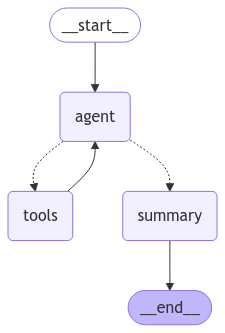

In [7]:
import json
from typing import (
    Annotated,
    Sequence,
    TypedDict,
    List,
)

from pydantic import BaseModel, Field

# LangChain / LangGraph imports
from langchain_core.messages import (
    SystemMessage,
    AIMessage,
    HumanMessage,
    BaseMessage,
    ToolMessage,
)
from langchain_core.tools import StructuredTool
from langchain_core.runnables import RunnableConfig

from langgraph.prebuilt import InjectedStore
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from langgraph.checkpoint.memory import MemorySaver
from langchain.embeddings import init_embeddings
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

###############################################################################
# 1. Initialize memory + config
###############################################################################
in_memory_store = InMemoryStore(
    index={
        "embed": init_embeddings("huggingface:sentence-transformers/all-MiniLM-L6-v2"),
        "dims": 384,  # Embedding dimensions
    }
)

# A memory saver to checkpoint conversation states
checkpointer = MemorySaver()

# Initialize config with user & thread info
config = {}
config["configurable"] = {
    "user_id": "user_1",
    "thread_id": 0,
}

###############################################################################
# 2. Define MessagesState
###############################################################################
class MessagesState(TypedDict):
    """The state of the agent.

    The key 'messages' uses add_messages as a reducer,
    so each time this state is updated, new messages are appended.
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]

###############################################################################
# 3. Memory Tools
###############################################################################
def save_memory(summary_text: str, *, config: RunnableConfig, store: Annotated[BaseStore, InjectedStore()]) -> str:
    """Save the given memory for the current user and return the key."""
    user_id = config.get("configurable", {}).get("user_id", "unknown_user")
    namespace = ("memories", user_id)
    key = f"memory_{len(store.search(namespace))}"
    store.put(namespace, key, {"data": summary_text})
    return key


# Define a Pydantic schema for the save_memory tool (if needed elsewhere)
class RecallMemory(BaseModel):
    query: str = Field(..., title="Search Text", description="The text to search from memories for similar records.")
    top_k: int = Field(10, title="Number of Results", description="Number of results to retrieve.")

def recall_memory(query: str, top_k: int = 10) -> str:
    """Retrieve user memories from in_memory_store."""
    user_id = config.get("configurable", {}).get("user_id", "unknown_user")
    namespace = ("memories", user_id)

    memories = [m.value["data"] for m in in_memory_store.search(namespace, query, limit=top_k)]
    joined = f"User memories: {', '.join(memories)}"
    return joined

# Create a StructuredTool from the function
recall_memory_tool = StructuredTool.from_function(
    func=recall_memory,
    name="Recall Memory Tool",
    description="""
      Retrieve memories relevant to the user's query from the vector store of saved data.
      Input must be a JSON string with the schema:
      {
        "query": "<text to search>",
        "top_k": 10
      }
      """,
    args_schema=RecallMemory,
    response_format="content",
    return_direct=False,
    verbose=False
)

###############################################################################
# 4. Summarize Node (using StructuredTool)
###############################################################################
# Define a Pydantic schema for the Summary tool
class SummariseConversation(BaseModel):
    summary_text: str = Field(..., title="text", description="Summary of Conversation")

def summarise_node(summary_text: str):
    """
    Final node that summarizes the entire conversation for the current thread,
    saves it in memory, increments the thread_id, and ends the conversation.
    Returns a confirmation string.
    """
    user_id = config["configurable"]["user_id"]
    current_thread_id = config["configurable"]["thread_id"]
    new_thread_id = str(int(current_thread_id) + 1)

    # Prepare configuration for saving memory with updated thread id
    config_for_saving = {
        "configurable": {
            "user_id": user_id,
            "thread_id": new_thread_id
        }
    }
    key = save_memory(summary_text, config=config_for_saving, store=in_memory_store)
    return f"Summary saved under key: {key}"

# Create a StructuredTool from the function (this wraps summarise_node)
summarise_tool = StructuredTool.from_function(
    func=summarise_node,
    name="Summary Tool",
    description="""
      Summarize the current conversation in no more than
      1000 words. Also retain any unanswered quiz questions along with
      your internal answers so the next conversation thread can continue.
      Do not reveal solutions to the user yet. Use this tool to save
      the current conversation to memory and then end the conversation.

      Input must be a JSON string with the schema:
      {
        "summary_text": "<Your summary of conversation>"
      }
      """,
    args_schema=SummariseConversation,
    response_format="content",
    return_direct=False,
    verbose=False
)

###############################################################################
# 5. Build the Graph
###############################################################################
graph_builder = StateGraph(MessagesState)

# Use the built-in ToolNode from langgraph that calls any declared tools.
tools = [
    mcq_retriever_tool,
    web_extraction_tool,
    ensemble_retriever_tool,
    general_retriever_tool,
    in_memory_retriever_tool,
    recall_memory_tool,
    summarise_tool,  # Use the StructuredTool version, not the raw function
]

tool_node = ToolNode(tools=tools)
end_node = ToolNode(tools=[summarise_tool])  # Use summarise_tool for end node

# Wrap your model with tools
llm_with_tools = model.bind_tools(tools)

###############################################################################
# 6. The agent's main node: call_model
###############################################################################
def call_model(state: MessagesState, config: RunnableConfig):
    """
    The main agent node that calls the LLM with the user + system messages.
    Since our vLLM chat wrapper expects a list of BaseMessage objects,
    we convert any dict messages to HumanMessage objects.
    If the LLM requests a tool call, we'll route to the 'tools' node next
    (depending on the condition).
    """
    # Convert message dicts to HumanMessage instances if needed.
    messages = []
    for m in state["messages"]:
        if isinstance(m, dict):
            # Use role from dict (defaulting to 'user' if missing)
            messages.append(HumanMessage(content=m.get("content", ""), role=m.get("role", "user")))
        else:
            messages.append(m)

    # Invoke the LLM (with tools) using the converted messages.
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

###############################################################################
# 7. Add Nodes & Edges, Then Compile
###############################################################################
graph_builder.add_node("agent", call_model)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("summary", end_node)

# Entry point
graph_builder.set_entry_point("agent")

# If LLM requests a tool, go to "tools", otherwise go to "summary"
graph_builder.add_conditional_edges("agent", tools_condition, ["tools", "summary"])

# If we used a tool, return to the agent for final answer or more tools
graph_builder.add_edge("tools", "agent")

# Final node
graph_builder.set_finish_point("summary")

# Compile the graph with checkpointing and persistent store
graph = graph_builder.compile(checkpointer=checkpointer, store=in_memory_store)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [8]:
# URL
url1 = "https://www.ibm.com/think/topics/artificial-intelligence"
url2 = "https://www.ibm.com/think/topics/machine-learning"

question_1 = (f"Find out about Deep Learning from databases. Then search from website: {url1} and {url2} with web extraction tool")
question_2 = "Provide 5 MCQ questions on Artificial Intelligence to help me with practice."
question_3 = "Here are my answers: 1. A, 2. B, 3. C, 4. D, 5. E. Please check mu answer, provide reasons for my wrong answers and provide the correct answers with explanations."
question_4 = "Provide another 5 MCQ questions on Artificial Intelligence to help me with practice."
question_5 = "Here are my answers: 1. A, 2. B, 3. C, 4. D, 5. E. Please check mu answer, provide reasons for my wrong answers and provide the correct answers with explanations."
question_6 = "Provide a study quide to help me learn for my wrong answers for the MCQ questions."
question_7 = "Based on your reference databases only, provide a study quide on Deep Learning."
question_8 = "Based on your memory, provide a summary of our conversation."

# Grab the current user_id and thread_id from config
user_id = "user_1"

# Get last thread_id
last_thread_id = config["configurable"]["thread_id"]
thread_id = str(int(last_thread_id) + 1)

# Print Config
print(f"Conversation Thread ID: {last_thread_id} -> {thread_id}")

# Update the config with the new thread_id
config = {"configurable": {"thread_id": thread_id, "user_id": user_id}}

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": question_8}]},
    config, # Pass the thread-level persistence to the graph
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()



Conversation Thread ID: 0 -> 1
================================ Human Message =================================

Based on your memory, provide a summary of our conversation.


ValidationError: 3 validation errors for HumanMessage
content.str
  Input should be a valid string [type=string_type, input_value=[HumanMessage(content='Ba...ff0-bca1-f2b36597a8c7')], input_type=list]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].0.str
  Input should be a valid string [type=string_type, input_value=HumanMessage(content='Bas...4ff0-bca1-f2b36597a8c7'), input_type=HumanMessage]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].0.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=HumanMessage(content='Bas...4ff0-bca1-f2b36597a8c7'), input_type=HumanMessage]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type